In [2]:
import datetime
import numpy as np
import sys
import os
import xarray as xr
import cmath
import string

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
raw_dir = os.path.join(data_dir,'raw')
fig_dir = os.path.join(proj_dir,'reports','devel','figures')
tab_dir = os.path.join(proj_dir,'reports','devel','tables')

src_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(src_dir)
#sys.path.append('/home/ubuntu/bigStick/antarctic_melting/src/tools')

%load_ext autoreload
%autoreload 2


#from compare_tide import compare_tide
#from compare_atg import compare_atg
#from grid_ttide import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#load data at certain time range
file_path = os.path.join(raw_dir,'scratch','waom10_te','ocean_his.nc')
zeta = xr.open_mfdataset(file_path).sel(ocean_time=slice('2007-1-1','2007-12-31')).zeta

#load grid
file_path = os.path.join(raw_dir,'waom_frc','waom10_grd.nc')
grid = xr.open_dataset(file_path)

print('record length: %.1f days' %(zeta.ocean_time.shape[0]/24))

record length: 365.0 days


In [14]:
#define functions that calculate rmsd to atg
from scipy.spatial import KDTree
import ttide as tt
import scipy.io as sio
from log_progress import log_progress
from cartesian_grid_2d import haversine

def compare_atg(roms_zeta_da,grid,
                atg_mat_path=os.path.join('projdir','data','analysis','external','atg','ATG_ocean_height_2010_0908.mat'),
                stime=datetime.datetime(2007,1,1),constit_list = ['M2','O1'],
                station_list=np.arange(1,109),print_flag=True):

    print('stime = ',stime,' constits = ',constit_list,'stations = ',station_list)
    
    mat_content = sio.loadmat(atg_mat_path)
    atg_data = mat_content['atg']

    station_dict = {}

    for station in log_progress(station_list,name='stations'):

        station_dict[station] = {}

        atg_dict = read_atg(atg_data,station,constit_list)
        lat = atg_dict['lat']
        lon = atg_dict['lon']
        eta_rho,xi_rho,dist,tt_dict = station_ttide(roms_zeta_da,grid,lat,lon,stime,constit_list)

        station_dict[station]['atg'] = atg_dict
        station_dict[station]['tt'] = tt_dict
        station_dict[station]['dist'] = dist
        station_dict[station]['eta_rho'] = eta_rho
        station_dict[station]['xi_rho'] = xi_rho
        
    rmse_dict = calc_rmse(station_dict,constit_list)

    if print_flag == True:
        print_station_dict(station_dict,constit_list)
        print_rmse(rmse_dict,constit_list)

    return station_dict,rmse_dict


def read_atg(atg_data,site_id,constit_list):

    site_data = {}
    for key in ['site_id','name','lat','lon','amp','Gphase','reclen','delta_t','meas_type','ref']:
        site_data[key] =np.squeeze(atg_data[key][0,0][site_id-1])
    site_data['constit']=np.squeeze(atg_data['constit'][0,0][:])
    site_data['name'] = site_data['name'].strip()

    cm2m = 1.0/100.0
    for const in constit_list:

        atg_con_ind = list(site_data['constit']).index(const)
        site_data[const]=np.array([site_data['amp'][atg_con_ind]*cm2m, site_data['Gphase'][atg_con_ind]])

    return site_data

def station_ttide(zeta_da,grid,lat_t,lon_t,stime,constit_list):

    zeta_flat = zeta_da.stack(etaxi = ('eta_rho','xi_rho'))
    grid_flat = grid.stack(etaxi = ('eta_rho','xi_rho'))

    lat_s = grid_flat.lat_rho.values[grid_flat.mask_rho.values==True]
    lon_s = grid_flat.lon_rho.values[grid_flat.mask_rho.values==True]
    zeta_s = zeta_flat.values[:,grid_flat.mask_rho.values==True]
    etaxi_s = zeta_flat.etaxi.values[grid_flat.mask_rho.values==True]

    points = np.column_stack((lat_s,lon_s))
    tree = KDTree(points)

    target = np.column_stack((lat_t,lon_t))
    dist, ind = tree.query(target)
    
    lat_r = lat_s[ind]
    lon_r = lon_s[ind]
    dist = haversine(lon_t,lat_t,lon_r,lat_r)

    tmp={}
    tmp['roms_signal'] = zeta_s[:,ind].squeeze()
    
    eta_rho,xi_rho = np.fromstring(str(etaxi_s[ind])[2:-2], sep=', ',dtype=int)
    
    try:
        tmp['t_tide']=tt.t_tide(tmp['roms_signal'],dt=1,stime=stime,lat=lat_r,out_style=None)
        
        for const in constit_list:
            tide_con_ind = list(tmp['t_tide']['nameu']).index(str.encode(const+'  '))
            tmp[const]=tmp['t_tide']['tidecon'][tide_con_ind]
            
    except TypeError:
        for const in constit_list:
             tmp[const]=[np.nan,np.nan,np.nan,np.nan]

    return eta_rho,xi_rho,dist,tmp

def calc_rmse(station_dict,constit_list):

    d2r = np.pi/180  
    const_rmse={}
    sum_complex_mse = 0
    sum_excluded = 0
    
    for constit in constit_list:

        tt_amp = []
        atg_amp = []

        tt_phi =[]
        atg_phi =[]

        tt_z = []
        atg_z = []

        for station,data in station_dict.items():

            if data['dist'] > 50000:              
                print('Excluded Station '+data['atg']['name']+', since dist to roms point > 50km')
                sum_excluded+=1
                
            elif np.isnan(data['tt'][constit][0]):    
                print('Excluded Station '+data['atg']['name']+', since roms ttide failed')
                sum_excluded+=1
                
            elif np.isnan(data['atg'][constit][0]):    
                print('Excluded Station '+data['atg']['name']+', since atg failed')
                sum_excluded+=1
                
            else:

                tt_amp.append(data['tt'][constit][0])
                atg_amp.append(data['atg'][constit][0])

                tt_phi.append(data['tt'][constit][2])
                atg_phi.append(data['atg'][constit][1])

                tt_z.append(data['tt'][constit][0] * np.exp(1j*data['tt'][constit][2]*d2r))
                atg_z.append(data['atg'][constit][0] * np.exp(1j*data['atg'][constit][1]*d2r))
                
        tt_amp = np.array(tt_amp)
        atg_amp=np.array(atg_amp)
        tt_phi = np.array(tt_phi)
        atg_phi = np.array(atg_phi)
        tt_z = np.array(tt_z)
        atg_z = np.array(atg_z)
        
        const_rmse[constit] = {}
        
        const_rmse[constit] = {}

        const_rmse[constit]['amp']= np.sqrt(np.nanmean((tt_amp - atg_amp) ** 2))
        
        const_rmse[constit]['amp_atg']= np.nanmean(atg_amp)
        
        const_rmse[constit]['rel_amp']= np.sqrt(np.nanmean(((tt_amp - atg_amp)/atg_amp) ** 2))
        
        phi_diff = np.abs(tt_phi-atg_phi)
        phi_diff[phi_diff>180]-=360
    
        const_rmse[constit]['phase'] = np.sqrt(np.nanmean(phi_diff ** 2))
        
        #complex_mse = 0.5*np.nanmean(((tt_z-atg_z)*np.conjugate(tt_z-atg_z)).real)
        complex_mse = 0.5*np.nanmean(abs(tt_z-atg_z)**2)
        
        const_rmse[constit]['complex_amp']=np.sqrt(complex_mse)
        
        const_rmse[constit]['complex_rel_amp']=np.sqrt(np.nanmean((abs(tt_z-atg_z)/abs(atg_z))**2))
        
        sum_complex_mse += complex_mse
        
        const_rmse[constit]['nb_excluded'] = sum_excluded

    const_rmse['combined_complex'] = np.sqrt(sum_complex_mse)
    
    return const_rmse
 
def print_station_dict(station_dict,constit_list):
    print("Station ID || Amp(amp_err)[m]:  atg   roms || phase(phase_err)[deg]:  atg   roms || Station Name; RecLen [days]; Nearest Neibour [km]")
    for constit in constit_list:
        print(constit)
        for station_id,data in station_dict.items():
            print(station_id,"|| %0.2f"%data['atg'][constit][0]," %0.2f(%0.2f) "%(data['tt'][constit][0],data['tt'][constit][1]),\
                  "|| %0.2f"%data['atg'][constit][1]," %0.2f(%0.2f) "%(data['tt'][constit][2],data['tt'][constit][3]),\
                  "|| ",data['atg']['name']," ",data['atg']['reclen'],' %0.2f' %data['dist'][0])

def print_rmse(rmse_dict,constit_list):

    for constit in constit_list:
        data = rmse_dict[constit]
        
        print(constit+' RMSD: amp = %.2f m    phase = %.2f deg   complex amp = %.2f m   amp_atg = %.2f m  rel amp = %.2f '\
              %(data['amp'],data['phase'],data['complex_amp'],data['amp_atg'],data['amp']/data['amp_atg']))
        print('Number excluded records: ',rmse_dict[constit]['nb_excluded'])
        
    print('Combined complex RMSD: %.2f'%rmse_dict['combined_complex'])

def calc_diffs(stations_dict,constit):

    deg2rad = np.pi/180
    station = []
    xi = []
    eta = []
    name = []
    amp = []
    rel_amp = []
    comp_amp = []
    comp_rel_amp = []
    sum_excl = 0

    
    for key,sta in stations_dict.items():

        if sta['dist'] > 50000 or np.isnan(sta['tt'][constit][0]) or np.isnan(sta['atg'][constit][0]):
            sum_excl += 1

        else:
            station.append(key)
            name.append(sta['atg']['name'])
            xi.append(sta['xi_rho'])
            eta.append(sta['eta_rho'])
            tt_amp = sta['tt'][constit][0]
            tt_phase = sta['tt'][constit][2]*deg2rad
            atg_amp = sta['atg'][constit][0]
            atg_phase = sta['atg'][constit][1]*deg2rad

            atg_z = cmath.rect(atg_amp,atg_phase)
            tt_z = cmath.rect(tt_amp,tt_phase)

            #diff.append(abs(atg_z-tt_z)/2*100)
            
            amp.append(tt_amp-atg_amp)
            
            rel_amp.append(abs((tt_amp-atg_amp)/atg_amp))
            
            comp_amp.append(abs(atg_z-tt_z))
            
            comp_rel_amp.append(abs(tt_z-atg_z)/abs(atg_z))          

    return {'station_id':station,'station_name':name,'xi':xi,'eta':eta,
            'amp':np.array(amp),'rel_amp':np.array(rel_amp),
            'comp_amp':np.array(comp_amp),'comp_rel_amp':np.array(comp_rel_amp),
            'excl':sum_excl}

In [4]:
# calculate rms
stations,rms = compare_atg(zeta,grid,stime=datetime.datetime(2007,1,1),constit_list=['M2','S2','O1','K1'],station_list=range(0,109))

stime =  2007-01-01 00:00:00  constits =  ['M2', 'S2', 'O1', 'K1'] stations =  range(0, 109)


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_tide.py:620: RuntimeWarning: invalid value encountered in true_divide
  snr = (tidecon[:, 0] / tidecon[:, 1]) ** 2
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_predic.py:57: RuntimeWarning: invalid value encountered in true_divide
  snr = (tidecon[:, 0] / tidecon[:, 1]) ** 2
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_predic.py:60: RuntimeWarning: invalid value encountered in greater
  I = snr > synth


No predictions with this SNR
Excluded Station PTC_4_2_21, since dist to roms point > 50km
Excluded Station PTC_4_2_32, since dist to roms point > 50km
Excluded Station PTC_4_1_02 (Station "Kathy"), since dist to roms point > 50km
Excluded Station 65300- Macquarie Island, since dist to roms point > 50km
Excluded Station 20090- Heard Island, since dist to roms point > 50km
Excluded Station ROPEX C1, since dist to roms point > 50km
Excluded Station PTC_4_2_21, since dist to roms point > 50km
Excluded Station PTC_4_2_32, since dist to roms point > 50km
Excluded Station PTC_4_1_02 (Station "Kathy"), since dist to roms point > 50km
Excluded Station 65300- Macquarie Island, since dist to roms point > 50km
Excluded Station 20090- Heard Island, since dist to roms point > 50km
Excluded Station ROPEX C1, since dist to roms point > 50km
Excluded Station PTC_4_2_21, since dist to roms point > 50km
Excluded Station PTC_4_2_32, since dist to roms point > 50km
Excluded Station PTC_4_1_02 (Station "Kat

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in greater


 0.10(0.00)  || 120.00  131.59(0.05)  ||  PTC_4_1_03  (Station "Flicki")   21.0  3959.75
23 || 0.11  0.10(0.00)  || 8.87  2.48(0.15)  ||  20080- Mawson   365.0  2433.13
24 || 0.18  0.18(0.00)  || 307.09  297.21(0.13)  ||  20100- Davis   365.0  1793.10
25 || 0.17  0.17(0.00)  || 200.09  192.49(0.14)  ||  20120- Casey   365.0  2321.33
26 || 0.09  0.09(0.00)  || 57.05  78.95(0.17)  ||  65300- Macquarie Island   365.0  1015840.93
27 || 0.07  0.04(0.00)  || 252.81  260.65(0.48)  ||  20090- Heard Island   52.0  661224.99
28 || 0.10  0.20(0.00)  || 112.33  127.42(0.39)  ||  Base (gravity measurements on the RIS)   44.0  4020.69
29 || 0.04  0.06(0.00)  || 130.94  277.04(0.94)  ||  c13  (gravity measurements on the RIS)   34.0  976.49
30 || 0.02  0.06(0.00)  || 162.57  227.33(0.95)  ||  c16  (gravity measurements on the RIS)   45.0  11575.99
31 || 0.07  0.07(0.00)  || 26.69  10.07(0.56)  ||  c36  (gravity measurements on the RIS)   34.0  9394.14
32 || 0.11  0.18(0.00)  || 141.86  199.04(0.67)  

43 || 0.40  0.34(0.00)  || 61.70  55.84(0.29)  ||  Rutford GL Tilt/Grav   43.0  6788.40
44 || 0.24  0.19(0.00)  || 310.51  309.36(0.20)  ||  Syowa   365.0  15334.99
45 || 0.29  0.24(0.00)  || 45.00  53.06(0.13)  ||  Ardley Cove   44.0  2745.88
46 || 0.26  0.23(0.00)  || 50.00  51.15(0.13)  ||  Gurrachaga   41.0  5419.48
47 || 0.28  0.22(0.00)  || 49.00  49.57(0.08)  ||  Half Moon Is.   38.0  3493.61
48 || 0.29  0.23(0.00)  || 55.00  51.33(0.08)  ||  Pendulum Cove   19.0  10142.51
49 || 0.29  0.23(0.00)  || 48.00  51.64(0.09)  ||  Whalers Cove   12.0  8676.83
50 || 0.40  0.28(0.00)  || 35.00  39.39(0.11)  ||  Bahia Esperanza   547.0  3004.86
51 || 0.33  0.27(0.00)  || 52.00  53.40(0.11)  ||  Mikkelsen   25.0  5832.06
52 || 0.32  0.27(0.00)  || 59.00  53.87(0.10)  ||  Primavera   44.0  1838.19
53 || 0.30  0.26(0.00)  || 60.00  58.59(0.13)  ||  Gerlache C   29.0  3502.76
54 || 0.28  0.24(0.00)  || 65.90  64.79(0.15)  ||  Palmer   30.0  2780.35
55 || 0.29  0.00(0.00)  || 68.00  275.90(0.00

53 || 0.32  0.31(0.00)  || 78.00  75.71(0.09)  ||  Gerlache C   29.0  3502.76
54 || 0.31  0.27(0.00)  || 83.10  86.24(0.13)  ||  Palmer   30.0  2780.35
55 || 0.29  0.00(0.00)  || 82.00  357.80(0.00)  ||  Lokcroy   19.0  9958.84
56 || 0.33  0.32(0.00)  || 76.00  76.21(0.12)  ||  Brown   699.0  15047.96
57 || 0.32  0.27(0.00)  || 86.00  86.65(0.13)  ||  Groussac   59.0  10840.30
58 || 0.41  0.20(0.00)  || 46.00  51.06(0.23)  ||  Seymour Is. (Marambio Base)   32.0  10068.52
59 || 0.42  0.25(0.00)  || 32.00  48.94(0.17)  ||  Larsen Nunatak (Matenzio Base)   44.0  5807.35
60 || 0.33  0.32(0.00)  || 99.00  94.46(0.12)  ||  Eklund Islands   45.0  5395.64
61 || 0.32  0.28(0.00)  || 93.00  82.70(0.12)  ||  Marguerite Bay   16.0  5163.77
62 || 0.18  0.31(0.00)  || 84.00  88.89(0.14)  ||  Moutonnee Lake (Looks Bad)   15.0  5554.21
63 || 0.30  0.31(0.00)  || 88.00  88.89(0.14)  ||  Ablation Lake   54.0  10785.64
64 || 0.31  0.32(0.00)  || 96.00  88.19(0.14)  ||  Hobbs Pool   15.0  11095.10
65 || 0

In [15]:
import pickle
out_path = os.path.join(data_dir,'processed','atg_comp.pkl')
a_file = open(out_path, "rb")
atg_comp = pickle.load(a_file)
stations,rms = atg_comp['stations'],atg_comp['rmse']

In [16]:
stations.pop(70) #Amery grounding line is of the show as partially grounded! discrad!
stations.pop(43) #Rutford is in grouning zone
stations.pop(106) # Evans in G Zome
rmse_dict = calc_rmse(stations,['M2','S2','O1','K1'])
print_rmse(rmse_dict,['M2','S2','O1','K1'])

Excluded Station PTC_4_2_21, since dist to roms point > 50km
Excluded Station PTC_4_2_32, since dist to roms point > 50km
Excluded Station PTC_4_1_02 (Station "Kathy"), since dist to roms point > 50km
Excluded Station 65300- Macquarie Island, since dist to roms point > 50km
Excluded Station 20090- Heard Island, since dist to roms point > 50km
Excluded Station ROPEX C1, since dist to roms point > 50km
Excluded Station PTC_4_2_21, since dist to roms point > 50km
Excluded Station PTC_4_2_32, since dist to roms point > 50km
Excluded Station PTC_4_1_02 (Station "Kathy"), since dist to roms point > 50km
Excluded Station 65300- Macquarie Island, since dist to roms point > 50km
Excluded Station 20090- Heard Island, since dist to roms point > 50km
Excluded Station ROPEX C1, since dist to roms point > 50km
Excluded Station PTC_4_2_21, since dist to roms point > 50km
Excluded Station PTC_4_2_32, since dist to roms point > 50km
Excluded Station PTC_4_1_02 (Station "Kathy"), since dist to roms poin

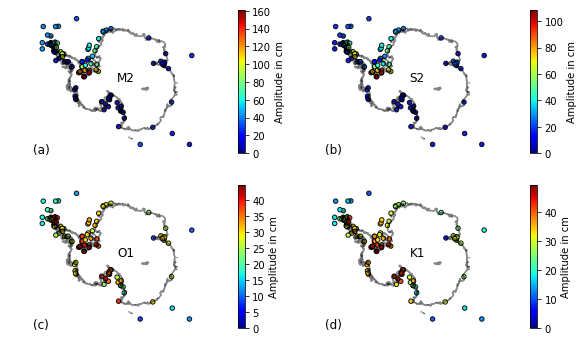

In [357]:
fig,axes = plt.subplots(2,2,figsize=(11.69,8.27))
const = ['M2','S2','O1','K1']

n=0
for const,ax in zip(const,axes.flatten()):   
    
    ams = []
    xi = []
    eta = []
    for key,station in stations.items():
        ams.append(station['atg'][const][0])
        xi.append(station['xi_rho'])
        eta.append(station['eta_rho'])
        
    ams = np.array(ams)
    
    ax.contour(grid.mask_rho.values,colors='k',alpha=0.1)
    colors = ams*100
    std = np.nanstd(colors)
    
    scatter = ax.scatter(xi,eta,s=30,c=colors,
                         edgecolors='k',alpha=0.9,cmap='jet',
                         vmin = 0)
    
    plt.colorbar(scatter,ax=ax,label='Amplitude in cm')
    ax.set_aspect('equal')
    ax.axis('off')
    
    ax.text(0.5, 0.5, f'{const}', transform=ax.transAxes, 
            size=12)
    
    
    ax.text(0.0, 0.0, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
    n+=1
    
    ax.set_anchor('SW')
    
plt.tight_layout()
    
out_path = os.path.join(fig_dir,'tide_eval_map_ampl_atg.png')
fig.savefig(out_path,format='png',dpi=400,bbox_inches = "tight")

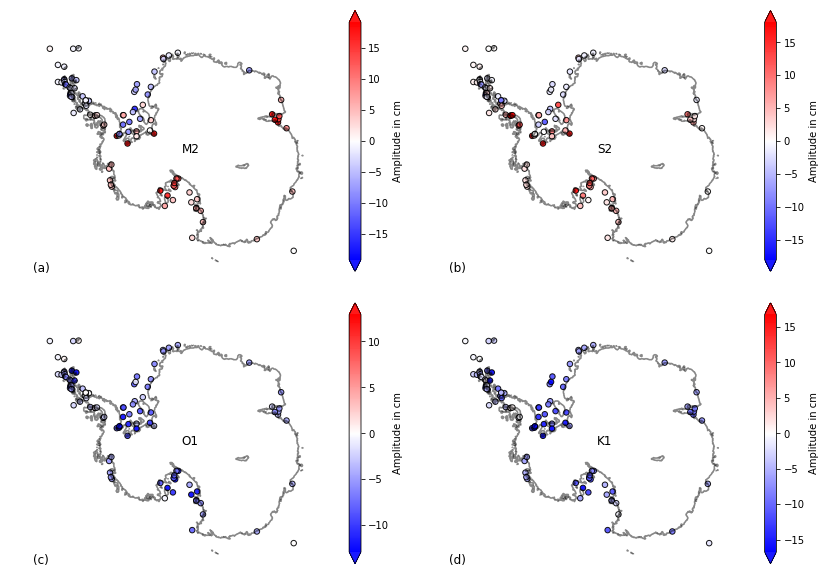

In [314]:
%matplotlib inline
fig,axes = plt.subplots(2,2,figsize=(11.69,8.27))
const = ['M2','S2','O1','K1']

n=0
for const,ax in zip(const,axes.flatten()):   
    
    diffs = calc_diffs(stations,const)
    
    ax.contour(grid.mask_rho.values,colors='k',alpha=0.1)
    colors = diffs['amp']*100
    std = np.nanstd(colors)
    #vmax = max(colors.max(),-colors.min())
    vmax = max(np.quantile(colors,0.95),-np.quantile(colors,0.05))
    
    
    scatter = ax.scatter(diffs['xi'],diffs['eta'],s=30,c=colors,
                         edgecolors='k',alpha=0.9,cmap='bwr',vmin=-vmax,vmax=vmax)
    
    plt.colorbar(scatter,ax=ax,label='Amplitude in cm',extend='both')
    ax.set_aspect('equal')
    ax.axis('off')
    
    ax.text(0.5, 0.5, f'{const}', transform=ax.transAxes, 
            size=12)
    
    
    ax.text(0.0, 0.0, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
    n+=1
    
    ax.set_anchor('SW')
    
plt.tight_layout()
    
out_path = os.path.join(fig_dir,'tide_eval_map_ampl_diff.png')
fig.savefig(out_path,format='png',dpi=400,bbox_inches = "tight")

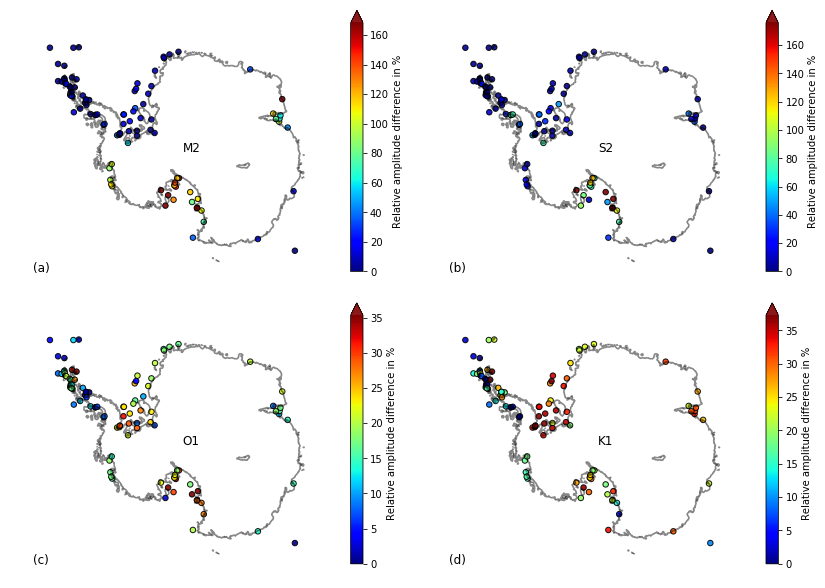

In [312]:
%matplotlib inline

fig,axes = plt.subplots(2,2,figsize=(11.69,8.27))
const = ['M2','S2','O1','K1']

n=0
for const,ax in zip(const,axes.flatten()):   
    
    diffs = calc_diffs(stations,const)
    colors = diffs['rel_amp']*100
    vmax = np.quantile(colors,0.95)
    
    ax.contour(grid.mask_rho.values,colors='k',alpha=0.1)
    scatter = ax.scatter(diffs['xi'],diffs['eta'],s=30,c=colors,
                         edgecolors='k',alpha=0.9,cmap='jet',
                          vmin = 0,vmax=vmax)
    plt.colorbar(scatter,ax=ax,label='Relative amplitude difference in %',extend='max')
    ax.set_aspect('equal')
    ax.axis('off')
    
    ax.text(0.5, 0.5, f'{const}', transform=ax.transAxes, 
            size=12)
    
    
    ax.text(0.0, 0.0, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
    n+=1
    
    ax.set_anchor('SW')
    
plt.tight_layout()
    
out_path = os.path.join(fig_dir,'tide_eval_map_rel_ampl_diff.png')
fig.savefig(out_path,format='png',dpi=400,bbox_inches = "tight")

In [310]:
def get_outs(stations_dict,const,save=False):
    diffs = calc_diffs(stations_dict,const)
    diffs = pd.DataFrame.from_dict(diffs)
    outs = diffs[diffs['rel_amp']>diffs['rel_amp'].quantile(.95)]
    
    if save:
        outs[['station_id','station_name','amp','rel_amp']].to_csv(os.path.join(tab_dir,'diff_rel_amp_outliers_'+const+'.csv'))
    
    return outs

for const in ['M2','S2','O1','K1']:
    outs = get_outs(stations,const,True)

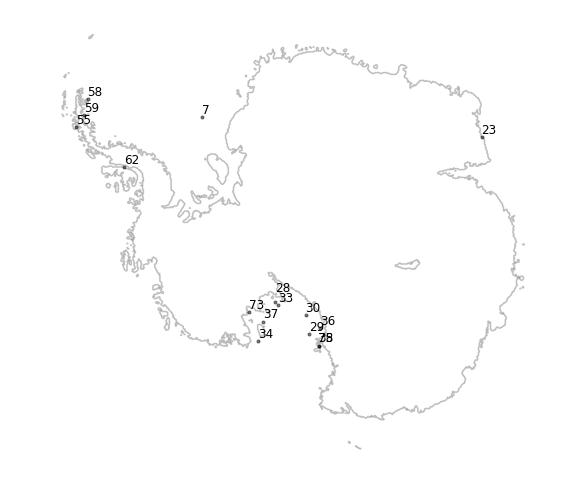

In [350]:
%matplotlib inline
fig,ax = plt.subplots(figsize=(8.27,8.27))   
    
ax.contour(grid.mask_rho.values,colors='k',alpha=0.05)
for key,station in stations.items():
    if key in [23,28,34,37,73,30,35,36,73,78,29,33,36,55,62,7,55,58,59,62]:
        xi = station['xi_rho']
        eta = station['eta_rho']
        x = station['xi_rho']/grid.xi_rho.size
        y = station['eta_rho']/grid.eta_rho.size+0.01
        ax.plot(xi,eta,marker='.',fillstyle='none',alpha=0.5,c='k')
        if key ==28:
            y+=0.015
        ax.text(x,y, str(key), transform=ax.transAxes, 
            size=12)

ax.set_aspect('equal')
ax.axis('off')
    
plt.tight_layout()
    
out_path = os.path.join(fig_dir,'tide_eval_map_stations.png')
fig.savefig(out_path,format='png',dpi=400,bbox_inches = "tight")